# Outlier analysis

The objective of this project is to practice finding outliers by implementing the Isolation Forest algorithm.

Author: <font color="white">Mario Muñoz Serrano</font>


Date: <font color="white">04/12/2022</font>

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np

# 1. Dataset

We will use the file annthyroid.csv that contains data about exams of the thyroid gland of 7,200 patients. In each exam, six attributes f1, f2, ..., f6 of each patient are measured. A ground-truth label indicating if the thyroid was finally found to be normal or abnormal is included in the dataset. Further information on this dataset can be found in this [free repository](https://odds.cs.stonybrook.edu/annthyroid-dataset/).

In [114]:
df = pd.read_csv('https://raw.githubusercontent.com/chatox/data-mining-course/master/practicum/data/annthyroid.csv', sep=',')

df['result'] = df['label'].apply(lambda x: 'abnormal' if x == 1 else 'normal')
df.drop(columns=['label'], inplace=True)

In [115]:
df.head()

,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.015,0.120,0.082,0.146,normal
1,0.24,0.00025,0.030,0.143,0.133,0.108,normal
2,0.47,0.00190,0.024,0.102,0.131,0.078,normal
3,0.64,0.00090,0.017,0.077,0.090,0.085,normal
4,0.23,0.00025,0.026,0.139,0.090,0.153,normal


First  we'll print the following metrics: 
- total number of patients
- number and percentage of patients with a normal thyroid
- number and percentage of patients with an abnormal thyroid.

To have a better understanding of our dataset

In [116]:
# Computations
total = len(df)
t_normal = len(df[df['result'] == 'normal'])
t_abnormal = len(df[df['result'] == 'abnormal'])

p_normal   = round((t_normal/total)*100, 2)
p_abnormal = round((t_abnormal/total)*100, 2)

# Output
print(f"Total patients   : {total}\t")
print(f"Normal thyroid   : {t_normal}")
print(f"Abnormal thyroid : {t_abnormal}")
print(f"Percentage with normal thyroid    : {p_normal}")
print(f"Percentage with abnormal thyroid  : {p_abnormal}")

Total patients   : 7200	
Normal thyroid   : 6666
Abnormal thyroid : 534
Percentage with normal thyroid    : 92.58
Percentage with abnormal thyroid  : 7.42


Now we can deep dive into each exam type and see a sample of 10 exams, and their centroids (average) for each exam result

Normal exams

In [117]:
# first 10 normal exams
df_normal = df[df['result'] == 'normal']
df_normal10 = df_normal.head(10)


print('First 10 normal exams')
df_normal10

First 10 normal exams


,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.015,0.120,0.082,0.146,normal
1,0.24,0.00025,0.030,0.143,0.133,0.108,normal
2,0.47,0.00190,0.024,0.102,0.131,0.078,normal
3,0.64,0.00090,0.017,0.077,0.090,0.085,normal
4,0.23,0.00025,0.026,0.139,0.090,0.153,normal
5,0.69,0.00025,0.016,0.086,0.070,0.123,normal
6,0.85,0.00025,0.023,0.128,0.104,0.121,normal
7,0.48,0.00208,0.020,0.086,0.078,0.110,normal
8,0.67,0.00130,0.024,0.087,0.109,0.080,normal
9,0.76,0.00010,0.029,0.124,0.128,0.097,normal


In [118]:
# "centroid" (average) of a normal exam
print("Centroid  of a normal exam")
df_normal10.describe().loc[['mean']]

Centroid  of a normal exam


,f1,f2,f3,f4,f5,f6
mean,0.576,0.000788,0.0224,0.1092,0.1015,0.1101


Abnormal exams

In [119]:
# First 10 abnormal exams
df_abnormal = df[df['result'] == 'abnormal']
df_abnormal10 = df_abnormal.head(10)

print('First 10 abnormal exams')
df_abnormal10

First 10 abnormal exams


,f1,f2,f3,f4,f5,f6,result
10,0.62,0.01100,0.0080,0.0730,0.074,0.0980,abnormal
19,0.50,0.06100,0.0096,0.0130,0.116,0.0110,abnormal
27,0.78,0.02500,0.0090,0.0500,0.084,0.0600,abnormal
43,0.61,0.00979,0.0040,0.0810,0.064,0.1260,abnormal
84,0.56,0.00820,0.0200,0.0660,0.094,0.0700,abnormal
105,0.73,0.04700,0.0110,0.0520,0.090,0.0580,abnormal
115,0.43,0.07000,0.0050,0.0029,0.104,0.0028,abnormal
116,0.42,0.03100,0.0080,0.0130,0.119,0.0110,abnormal
145,0.78,0.00630,0.0110,0.0560,0.086,0.0650,abnormal
147,0.53,0.02500,0.0040,0.0390,0.061,0.0640,abnormal


In [120]:
# "centroid" (average) of a abnormal exam
print("Centroid  of a abnormal exam")
df_abnormal10.describe().loc[['mean']]

Centroid  of a abnormal exam


,f1,f2,f3,f4,f5,f6
mean,0.596,0.029429,0.00896,0.04459,0.0892,0.05658


Identifying outliers in this dataset is possible because outliers seem to be quite different, across many dimensions, from inliers. To show this, we'll create all scatter plots of combinations of two dimensions in the data. In these, you can see that feature values for the minority class (represented by the color red), indeed are quite different from feature values for the majority class (represented by the color blue).

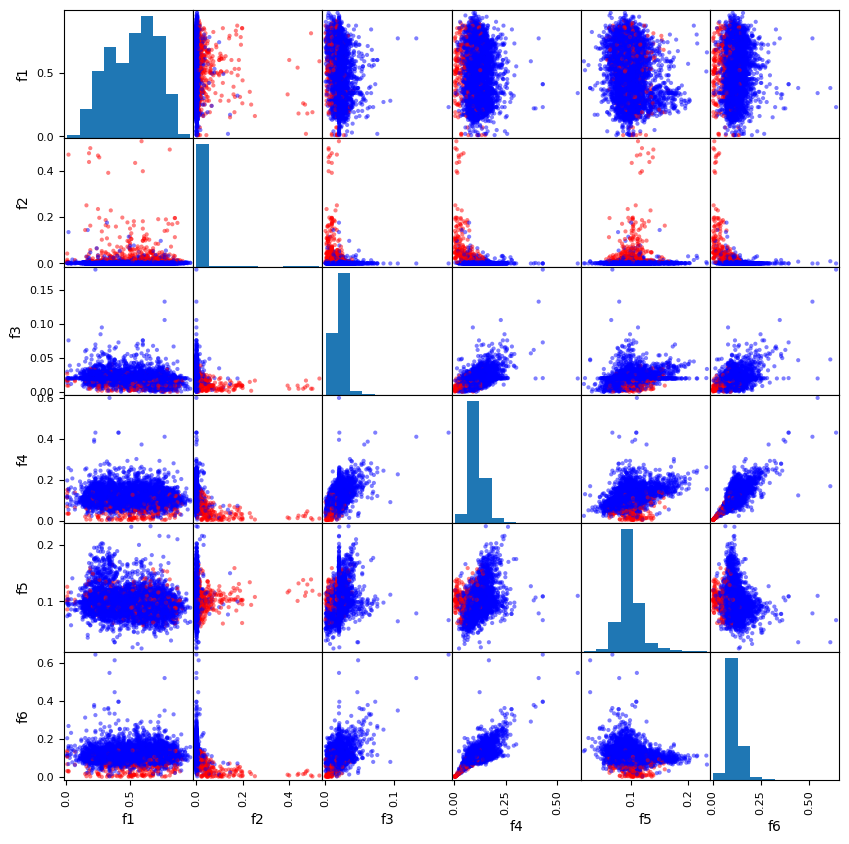

In [121]:
color_code = {'abnormal': 'red',
              'normal'  : 'blue'
              }

colors = df['result'].apply(lambda x: color_code[x])

plot = pd.plotting.scatter_matrix(df, c=colors, figsize=(10,10))

Looking at the plot above we can see clearly the difference between abnormal and normal exams in all possible combinations. Except in the following ones f5, f1 and f3, f5.

# Isolation Forests for Anomaly detection

Isolation Forest is an anomaly detection algorithm that works by isolating anomalies in the dataset. It's based on the concept of using decision trees to separate anomalies, which are typically fewer in number and more "isolated" compared to normal instances.


Here's a simplified breakdown of how an Isolation Forest works:

* Random Partitioning: The algorithm randomly selects a feature and a random value within the feature's range to create a partition between minimum and maximum values.

* Recursive Partitioning: It continues to create partitions by randomly selecting features and values. The process goes on recursively until the data points (instances) are isolated, i.e., each instance is contained in its partition.

* Anomaly Detection: Anomalies (outliers) are likely to require fewer partitions to be isolated compared to normal instances. This is based on the assumption that outliers are present in fewer partitions and are, therefore, easier to isolate.

* Scoring Anomalies: The isolation process in this tree-based structure helps in assigning an anomaly score to each instance. Anomalies that required fewer partitions to isolate will have lower path lengths in the tree and consequently higher anomaly scores.

* Thresholding: Based on the anomaly scores, a threshold can be set to classify instances as anomalies or normal data points. Instances scoring above this threshold are considered anomalies.

Key Advantages:

* It's efficient, especially with high-dimensional data.
* It doesn't require a lot of data preprocessing.
* It can handle both global and local anomalies.

Limitations:

* May not perform as well with clustered anomalies.
* Performance might degrade with datasets where anomalies are not significantly different from normal instances.

In summary, Isolation Forest works by constructing isolation trees to isolate anomalies efficiently by leveraging their property of being "isolated" from the rest of the data.

# 1. Create an isolation tree

## 1.1. Random partitioning

To allow the algorithm of randomly select a feature and a random value within the feature's range to create a partition between minimum and maximum values we will create three functions:
* `pick_random_dimension(df, columns_to_ignore)` 
* `pick_random_split(df, dimension)`
* `split_dataset(df, dimension, split)`


In [122]:
def pick_random_dimension(df, columns_to_ignore):

  dimensions = [x for x in list(df.columns) if x not in columns_to_ignore]
  
  return dimensions[random.randrange(len(dimensions))]
    

In [123]:
def pick_random_split(df, dimension):
    return random.uniform(np.min(df[dimension]), np.max(df[dimension]))
    

In [124]:
def split_dataset(df, dimension, split):
  return df[df[dimension]<=split], df[df[dimension]>split]

## 1.3. Create one isolation tree

First, let us add a patient identifier in column "id"

In [125]:
dfi = df.copy()
dfi.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(df))])
dfi

,id,f1,f2,f3,f4,f5,f6,result
0,P0001,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
1,P0002,0.24,0.00025,0.0300,0.143,0.133,0.1080,normal
2,P0003,0.47,0.00190,0.0240,0.102,0.131,0.0780,normal
3,P0004,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
4,P0005,0.23,0.00025,0.0260,0.139,0.090,0.1530,normal
...,...,...,...,...,...,...,...,...
7195,P7196,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,P7197,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,P7198,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal
7198,P7199,0.35,0.00280,0.0201,0.090,0.089,0.1010,normal


To allow Recursive Partitioning until the data points (instances) are isolated, i.e., each instance is contained in its partition. We've created the following function `isolation_tree(data, columns_to_ignore, min_items)`

In [126]:
# Function that builds an isolation tree
def isolation_tree(data, columns_to_ignore, min_items):
    tree = {}  # Initialize an empty dictionary to represent the tree

    # If the number of items in the dataset is less than or equal to the specified minimum items, return the data as a leaf node
    if len(data) <= min_items:
        return {"contents": data}  # Return a leaf node containing the data

    else:
        # Select a random dimension/feature that is not in the list of columns to ignore
        tree['dimension'] = pick_random_dimension(data, columns_to_ignore)
        
        # Choose a random split value for the selected dimension
        tree['split'] = pick_random_split(data, tree['dimension'])

        # Split the dataset into left and right based on the chosen dimension and split value
        (left, right) = split_dataset(data, tree['dimension'], tree['split'])

        # Recursively build the left and right subtrees using the split datasets
        tree['left'] = isolation_tree(left, columns_to_ignore, min_items)
        tree['right'] = isolation_tree(right, columns_to_ignore, min_items)

        return tree  # Return the constructed tree


In [127]:
mytree = isolation_tree(dfi, ['id', 'result'], 2000)

In [128]:
class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value)+"\n"
        if self.left:
            ret += self.left.__str__("<", level+1)
        if self.right:
            ret += self.right.__str__(">", level+1)
        return ret

    def __repr__(self):
        return self.value
    
def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['result'] == 'normal'])
        abnormal_count = len(data[data['result'] == 'abnormal'])
        description = "external node: %d normal + %d abnormal" % (normal_count, abnormal_count)
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = 'internal node: ' + tree['dimension'] + ' <= ' + ("%.2f" % tree['split'])
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right) )
        return n

In [129]:
print(tree_to_nodes(mytree))

:'internal node: f2 <= 0.11'
-<:'internal node: f4 <= 0.53'
--<:'internal node: f2 <= 0.02'
---<:'internal node: f1 <= 0.72'
----<:'internal node: f1 <= 0.20'
-----<:'external node: 329 normal + 16 abnormal'
----->:'internal node: f6 <= 0.39'
------<:'internal node: f5 <= 0.12'
-------<:'internal node: f4 <= 0.22'
--------<:'internal node: f1 <= 0.41'
---------<:'external node: 1421 normal + 46 abnormal'
--------->:'internal node: f2 <= 0.00'
----------<:'internal node: f2 <= 0.00'
-----------<:'external node: 1888 normal + 0 abnormal'
----------->:'external node: 1105 normal + 0 abnormal'
---------->:'external node: 289 normal + 165 abnormal'
-------->:'external node: 36 normal + 0 abnormal'
------->:'external node: 521 normal + 25 abnormal'
------>:'external node: 5 normal + 0 abnormal'
---->:'external node: 1021 normal + 67 abnormal'
--->:'external node: 46 normal + 165 abnormal'
-->:'external node: 1 normal + 0 abnormal'
->:'external node: 4 normal + 50 abnormal'



In [130]:
def get_max_tree_depth(tree):
    if not 'left' in tree and not 'right' in tree:
        return 0
    if tree['left']:
        max_left = get_max_tree_depth(tree['left'])
    if tree['right']:
        max_right = get_max_tree_depth(tree['right'])
        
    return max(max_left,max_right) + 1

In [131]:
print(get_max_tree_depth(mytree))

11


# 2. Create isolation forests and find depth of items


## 2.1. Create an isolation forest

In [132]:
def isolation_forest(df, columns_to_ignore, min_items, num_trees):
    return [isolation_tree(df, columns_to_ignore, min_items) for i in range(num_trees)]

In [133]:
myforest = isolation_forest(df, ['id', 'result'], 10, 20)
print(f"The forest has {len(myforest)} trees")

The forest has 20 trees


In [134]:
# MODIFY IF YOU SEE THAT IT IMPROVES THE SEPARATION BETWEEN CLASSES

min_items = 100
num_trees = 30

In [135]:
myforest = isolation_forest(dfi, ['id', 'result'], min_items, num_trees)
print("The forest has %d trees" % len(myforest))

The forest has 30 trees


In [136]:
for i in range(0, 3):
    print("Tree number %d" % i)
    print(tree_to_nodes(myforest[i]))
    print()

Tree number 0
:'internal node: f2 <= 0.40'
-<:'internal node: f4 <= 0.01'
--<:'external node: 1 normal + 34 abnormal'
-->:'internal node: f3 <= 0.15'
---<:'internal node: f3 <= 0.08'
----<:'internal node: f4 <= 0.50'
-----<:'internal node: f3 <= 0.07'
------<:'internal node: f1 <= 0.04'
-------<:'external node: 11 normal + 6 abnormal'
------->:'internal node: f4 <= 0.36'
--------<:'internal node: f5 <= 0.12'
---------<:'internal node: f4 <= 0.16'
----------<:'internal node: f3 <= 0.04'
-----------<:'internal node: f2 <= 0.07'
------------<:'internal node: f5 <= 0.08'
-------------<:'internal node: f6 <= 0.18'
--------------<:'internal node: f4 <= 0.08'
---------------<:'internal node: f3 <= 0.02'
----------------<:'internal node: f2 <= 0.04'
-----------------<:'internal node: f1 <= 0.43'
------------------<:'external node: 93 normal + 3 abnormal'
------------------>:'internal node: f6 <= 0.04'
-------------------<:'external node: 2 normal + 1 abnormal'
------------------->:'internal no

## 2.2. Find the average depth of an item

In [137]:
def find_element_depth_aux(tree, column_name, column_value, depth):
    
    if 'contents' in tree:
        # We are in a leaf node
        
        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your search criterion")
            return None
        else:
            return depth
    else:
        # We are in an internal node
        
        in_left = find_element_depth_aux(tree['left'], column_name, column_value, depth+1)
        if in_left == None:
            in_right = find_element_depth_aux(tree['right'], column_name, column_value, depth+1)
            return in_right
        else:
            return in_left
        
def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

In [138]:
def print_sample_depths(df, sample_size, tested_tree):

    for result in ['normal', 'abnormal']:
        print("Depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(sample_size))

        max_depth = get_max_tree_depth(tested_tree)
        for random_id in sample:
            print("- id=%s is at depth %d/%d" % (random_id, find_element_depth(tested_tree, "id", random_id), max_depth))
            
    
print("On shallow tree, having maximum depth %d" % get_max_tree_depth(mytree))
print_sample_depths(dfi, 5, mytree)
print()

print("On first tree of forest, having maximum depth %d" % get_max_tree_depth(myforest[0]))
print_sample_depths(dfi, 5, myforest[0])
print()


On shallow tree, having maximum depth 11
Depths for normal items
- id=P6219 is at depth 11/11
- id=P7035 is at depth 11/11
- id=P1684 is at depth 11/11
- id=P2809 is at depth 11/11
- id=P1664 is at depth 11/11
Depths for abnormal items
- id=P4377 is at depth 10/11
- id=P5412 is at depth 1/11
- id=P1514 is at depth 7/11
- id=P2414 is at depth 3/11
- id=P6148 is at depth 3/11

On first tree of forest, having maximum depth 39
Depths for normal items
- id=P0730 is at depth 21/39
- id=P4232 is at depth 15/39
- id=P1197 is at depth 39/39
- id=P4255 is at depth 19/39
- id=P1192 is at depth 33/39
Depths for abnormal items
- id=P3437 is at depth 27/39
- id=P6441 is at depth 22/39
- id=P5125 is at depth 1/39
- id=P4133 is at depth 17/39
- id=P5002 is at depth 20/39



Here, we can see that the depth of abnormal items is on average lower than the depth of normal items. Since the abnormal items are significantly different from normal items, it's easier to separate abnormal items from the rest of the items and the trees need less splits to isolate them.

In [139]:
def find_average_depth(forest, column_name, value):
    sum_depths = 0
    for tree in forest:
        sum_depths += find_element_depth(tree, column_name, value)
        
    average_depth = sum_depths/len(forest)

    return average_depth

In [140]:
for result in ['normal', 'abnormal']:
    print("Average depths for %s items" % result)
    
    sample = list(dfi[dfi['result'] == result]['id'].sample(5))
    
    for random_id in sample:
        print("- id=%s is at average depth %.1f" % (random_id, find_average_depth(myforest, "id", random_id)))
    
    print()

Average depths for normal items
- id=P6420 is at average depth 17.7
- id=P5574 is at average depth 16.6
- id=P5297 is at average depth 23.4
- id=P3570 is at average depth 7.2
- id=P2314 is at average depth 20.6

Average depths for abnormal items
- id=P4874 is at average depth 14.1
- id=P3098 is at average depth 11.2
- id=P1805 is at average depth 17.9
- id=P0117 is at average depth 7.7
- id=P5508 is at average depth 6.4



To make the "find_average_depth" function more efficient. We could perform binary search to find the different depths of the elements. Then the complexity would be O(number of trees x logn) instead of from O(number of trees x n)



# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

In [141]:
abnormal_point_ids = list(dfi[dfi['result'] == 'abnormal']['id'].sample(50))
normal_point_ids = list(dfi[dfi['result'] == 'normal']['id'].sample(50))

print("Normal point sample ids   : %s" % normal_point_ids)
print("Abnormal point sample ids : %s" % abnormal_point_ids)

Normal point sample ids   : ['P5108', 'P2410', 'P4656', 'P5646', 'P4350', 'P6993', 'P1937', 'P6745', 'P1203', 'P3166', 'P6426', 'P4236', 'P2684', 'P5434', 'P1833', 'P2054', 'P6064', 'P2710', 'P3692', 'P6735', 'P4240', 'P2418', 'P1139', 'P0844', 'P4773', 'P1259', 'P5621', 'P0502', 'P0926', 'P5272', 'P1317', 'P6094', 'P5565', 'P2678', 'P0010', 'P3645', 'P3535', 'P2015', 'P5825', 'P6984', 'P7094', 'P2061', 'P4935', 'P0838', 'P4717', 'P0574', 'P0947', 'P3156', 'P2905', 'P2271']
Abnormal point sample ids : ['P3473', 'P5909', 'P1166', 'P6025', 'P0733', 'P3920', 'P0696', 'P3908', 'P2132', 'P0767', 'P0344', 'P2172', 'P0839', 'P5234', 'P5449', 'P0117', 'P0146', 'P4094', 'P4396', 'P2042', 'P7118', 'P5113', 'P2157', 'P4077', 'P2046', 'P2994', 'P6818', 'P2057', 'P0028', 'P2147', 'P3246', 'P6482', 'P4611', 'P6041', 'P5004', 'P2629', 'P2375', 'P6295', 'P2237', 'P3929', 'P2668', 'P5463', 'P3800', 'P0545', 'P4901', 'P5614', 'P7103', 'P3430', 'P0216', 'P2729']


In [142]:
# LEAVE AS-IS

normal_depths = []
print("Depths of items in the 'normal' sample:")
for i in normal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    normal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'normal' sample:
 element id=P5108 is at average depth 16.10
 element id=P2410 is at average depth 16.60
 element id=P4656 is at average depth 19.77
 element id=P5646 is at average depth 12.50
 element id=P4350 is at average depth 20.27
 element id=P6993 is at average depth 18.47
 element id=P1937 is at average depth 22.93
 element id=P6745 is at average depth 23.27
 element id=P1203 is at average depth 16.17
 element id=P3166 is at average depth 21.33
 element id=P6426 is at average depth 20.03
 element id=P4236 is at average depth 14.47
 element id=P2684 is at average depth 24.77
 element id=P5434 is at average depth 20.83
 element id=P1833 is at average depth 21.17
 element id=P2054 is at average depth 15.83
 element id=P6064 is at average depth 21.43
 element id=P2710 is at average depth 16.10
 element id=P3692 is at average depth 16.13
 element id=P6735 is at average depth 11.97
 element id=P4240 is at average depth 19.70
 element id=P2418 is at average dept

In [143]:
# LEAVE AS-IS

abnormal_depths = []
print("Depths of items in the 'abnormal' sample:")
for i in abnormal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    abnormal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'abnormal' sample:
 element id=P3473 is at average depth 17.63
 element id=P5909 is at average depth 17.00
 element id=P1166 is at average depth 15.17
 element id=P6025 is at average depth 17.23
 element id=P0733 is at average depth 14.03
 element id=P3920 is at average depth 12.93
 element id=P0696 is at average depth 16.67
 element id=P3908 is at average depth 15.70
 element id=P2132 is at average depth 12.67
 element id=P0767 is at average depth 18.50
 element id=P0344 is at average depth 16.87
 element id=P2172 is at average depth 9.00
 element id=P0839 is at average depth 11.93
 element id=P5234 is at average depth 7.70
 element id=P5449 is at average depth 13.27
 element id=P0117 is at average depth 7.67
 element id=P0146 is at average depth 13.97
 element id=P4094 is at average depth 20.97
 element id=P4396 is at average depth 12.33
 element id=P2042 is at average depth 15.87
 element id=P7118 is at average depth 15.80
 element id=P5113 is at average depth

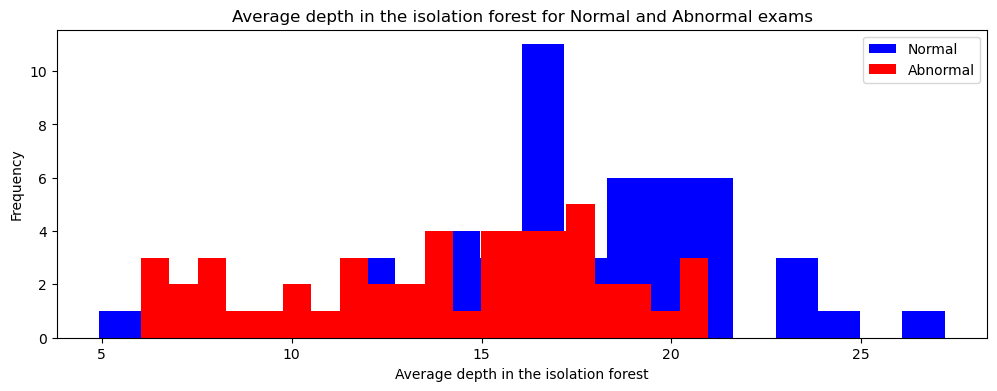

In [144]:
plt.figure(figsize=(12,4))
plt.hist(normal_depths, label='Normal', bins=20, density=False, color='blue')
plt.hist(abnormal_depths, label='Abnormal', bins=20, density=False, color='red')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.title('Average depth in the isolation forest for Normal and Abnormal exams')
plt.show()

As explained before, here we can see that the average depth in the isolation forest is significantly lower for anormal exams than for normal exams.

## 3.2. Compute outlier scores and conclude

In [145]:
# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma
def harmonic(s):
    return digamma(s + 1) + euler_gamma

In [146]:
def outlier_score_factory():
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n-1)/n)
    return lambda d: 2.0**(-d/c_n)

outlier_score = outlier_score_factory()

normal_scores = [outlier_score(d) for d in normal_depths]
abnormal_scores = [outlier_score(d) for d in abnormal_depths]

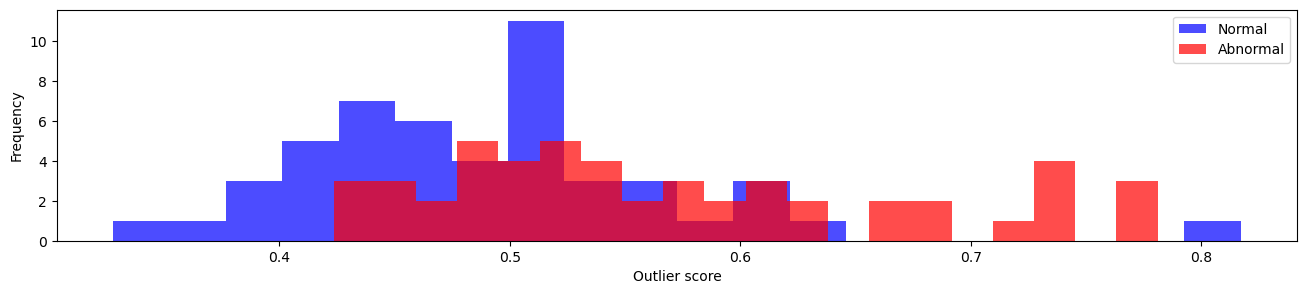

In [147]:
plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores, label='Normal', bins=20, density=False, color='blue', alpha=0.7)
plt.hist(abnormal_scores, label='Abnormal', bins=20, density=False, color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We observe that the bigger the outlier score, the more exams fall into the abnormal category. In this histogram, around 0.45 we start to see the outlier scores of abnormal exams. 

In [148]:
# Compute confussion matrix
def confu_matrix(normal_scores, abnormal_scores, threshold):
    confussion_matrix = {
        'false_normal': 0,
        'true_normal' : 0,
        'false_abnormal' : 0,
        'true_abnormal' : 0,
    }

    for score in normal_scores:
      if score < threshold:
        confussion_matrix['true_normal'] += 1
      else:
        confussion_matrix['false_normal'] += 1

    for score in abnormal_scores:
      if score < threshold:
        confussion_matrix['false_abnormal'] += 1
      else:
        confussion_matrix['true_abnormal'] += 1

    return confussion_matrix    

In [149]:
# Compute key stats for a given confussion matrix using certain threshold

def classification_info(cmat, threshold):

  total = (cmat['true_abnormal'] + cmat['false_normal'] + cmat['true_normal'] + cmat['false_abnormal'])
  true  = (cmat['true_abnormal'] + cmat['true_normal'])
  
  normal = (cmat['true_normal'] + cmat['false_normal'])
  abnormal = (cmat['true_abnormal'] + cmat['false_abnormal'])




  accuracy = true / total
  normal_precision = cmat['true_normal'] / normal
  abnormal_precision = cmat['true_abnormal'] / abnormal
  normal_recall = cmat['true_normal'] / (cmat['true_normal'] + cmat['false_abnormal'])
  abnormal_recall = cmat['true_abnormal'] / (cmat['true_abnormal'] + cmat['false_normal'])
  
  
  print(f"\n-----results for {threshold} outlier threshold-----\n")
  print(f"Accuracy: {round(accuracy, 2)}\n")
  print(f"Normal precision: {round(normal_precision, 2)}")
  print(f"Abnormal precision: {round(abnormal_precision, 2)}")    
  print(f"Recall (TPR): {round(normal_recall, 2)}")
  print(f"Specificity (TNR): {round(abnormal_recall, 2)}")
  print(f"False positive rate (FPR): {round(1- abnormal_recall, 2)}")
  print(f"False negative rate (FNR): {round(1- normal_recall, 2)}")

In [150]:
# Compute possible thresholds
th = [round(0.45 + i*0.01, 2) for i in range(7)]

print(th)

[0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51]


In [151]:
# See performance of different possible thresholds
for t in th:
  confussion_matrix = confu_matrix(normal_scores, abnormal_scores,  t)
  classification_info(confussion_matrix, t)


-----results for 0.45 outlier threshold-----

Accuracy: 0.63

Normal precision: 0.34
Abnormal precision: 0.92
Recall (TPR): 0.81
Specificity (TNR): 0.58
False positive rate (FPR): 0.42
False negative rate (FNR): 0.19

-----results for 0.46 outlier threshold-----

Accuracy: 0.64

Normal precision: 0.4
Abnormal precision: 0.88
Recall (TPR): 0.77
Specificity (TNR): 0.59
False positive rate (FPR): 0.41
False negative rate (FNR): 0.23

-----results for 0.47 outlier threshold-----

Accuracy: 0.64

Normal precision: 0.44
Abnormal precision: 0.84
Recall (TPR): 0.73
Specificity (TNR): 0.6
False positive rate (FPR): 0.4
False negative rate (FNR): 0.27

-----results for 0.48 outlier threshold-----

Accuracy: 0.65

Normal precision: 0.46
Abnormal precision: 0.84
Recall (TPR): 0.74
Specificity (TNR): 0.61
False positive rate (FPR): 0.39
False negative rate (FNR): 0.26

-----results for 0.49 outlier threshold-----

Accuracy: 0.64

Normal precision: 0.5
Abnormal precision: 0.78
Recall (TPR): 0.69
Sp

So, regarding to the theresholds the candidates with best acurracy are:

-----results for 0.48 outlier threshold-----

Accuracy: 0.7

* Normal precision: 0.58
* Abnormal precision: 0.82
* Recall (TPR): 0.76
* Specificity (TNR): 0.66
* False positive rate (FPR): 0.34
* False negative rate (FNR): 0.24

-----results for 0.49 outlier threshold-----

Accuracy: 0.7

* Normal precision: 0.62
* Abnormal precision: 0.78
* Recall (TPR): 0.74
* Specificity (TNR): 0.67
* False positive rate (FPR): 0.33
* False negative rate (FNR): 0.26

But taking into account we are in a medical case I prefer  to have a little less accuracy but higher recall.

This is why I will pick 0.45 as threshold

-----results for 0.45 outlier threshold-----

Accuracy: 0.68

* Normal precision: 0.38
* Abnormal precision: 0.98
* Recall (TPR): 0.95
* Specificity (TNR): 0.61
* False positive rate (FPR): 0.39
* False negative rate (FNR): 0.05

